# Full self-driving-car behavoural cloning

In [59]:
# Cloning dataset from github repo "track"
!git clone https://github.com/rslim087a/track


fatal: destination path 'track' already exists and is not an empty directory.


In [60]:
# show the repo content
!ls track

driving_log.csv  IMG


In [61]:
# load library for image generator 
!pip3 install imgaug

import stardand libraries 

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Collection Data

In [63]:
"""
Reading data with pandas
"""
# create the dir containing the data
datadir = 'track'
# read specific columns
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# load data with full path
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
# display the full column name
pd.set_option('display.max_colwidth', -1)
# load the first 5 rows
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


**Downloading data**

In [64]:
# extract the tail from the full for each column, where tail is the last string of the path
# for better dataframe representation
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


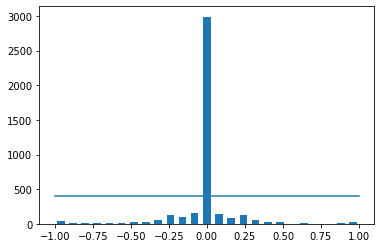

In [65]:
# Plot steering whell angle on histogram
# interval of the data to be displayed on the histo
num_bins = 25
# total of samples
samples_per_bin = 400
# split the 'steerin' values into distributed values
hist, bins = np.histogram(data['steering'], num_bins)
# print(hist)
# print(bins)
# define the interval [-1 : 1] center in zero 
# and devide the [-1 : 1]/2 for undouble the axes values cause of the add "bins[:-1]+ bins[1:]"
center = (bins[:-1]+ bins[1:]) * 0.5
# bar plot
# the histo shows an amount of value around zero, because of the nature of the track which is straight
# this creates a problem for NNwhich can bias the model to predict more zero angles
# To solve this : we fix a threshold(of 400) so that every value above it shall be rejected
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))

**Balacing data**

total data: 4053
removed: 2590
remaining: 1463


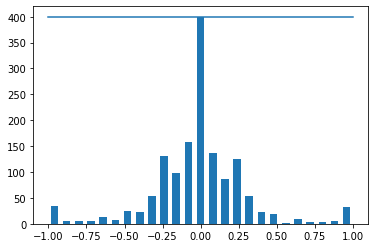

In [66]:
# Remove steering data above the threashold
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  # shuffle to spread the data and get more data variation 
  # we loose some data but we still have data from every part of the track
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

# print(list_)
# print(remove_list)
print('removed:', len(remove_list))

data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# we have more data gathered in the middle which due the recovery laps when the car drove in the middle of the road

**Training and Validation Split**


In [67]:
# Get data in a specific location (row) in the dataframe
print(data.iloc[56])

center      center_2018_07_16_17_11_50_749.jpg
left        left_2018_07_16_17_11_50_749.jpg  
right       right_2018_07_16_17_11_50_749.jpg 
steering   -0.05                              
throttle    1                                 
reverse     0                                 
speed       30.1899                           
Name: 95, dtype: object


In [68]:
# load all the images (left, center, right)
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # get center image
    # strip() eliminate any space inthe str name of the image
    image_path.append(os.path.join(datadir, center.strip()))
    # get the steering value associated to the center image
    steering.append(float(indexed_data[3]))
    # # left image append
    # image_path.append(os.path.join(datadir,left.strip()))
    # steering.append(float(indexed_data[3])+0.15)
    # # right image append
    # image_path.append(os.path.join(datadir,right.strip()))
    # steering.append(float(indexed_data[3])-0.15)
  # convert to array
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

**Preprocessing Image**

Training Samples: 1170
Valid Samples: 293


Text(0.5, 1.0, 'Validation set')

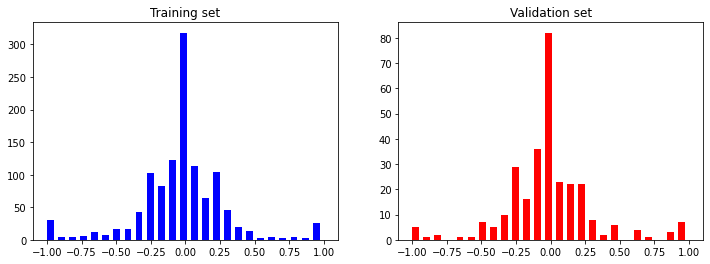

In [69]:
# load images (input) and steering angle (Labels) for training
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
# create training datas
"""
 $ from skilearn import train_test_split
 train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
 - image_paths : input 
 - steerings : label
 - test_size : 0.2 (20% slip for validation data)
 -random_state : 6 (init random seed to start the random generator) this value can be changed based on dataset
"""
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
# print(f'Training Samples: {len(X_train)}\nValid Samples: {len(X_valid)}')
# plot histo with matplotlib
"""
subplots(1, 2, figsize=(12, 4))
1 : one row
2 : 2 plots
figsize : 12x4
"""
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

**Generator augmentation techniques**

Text(0.5, 1.0, 'Zoomed Image')

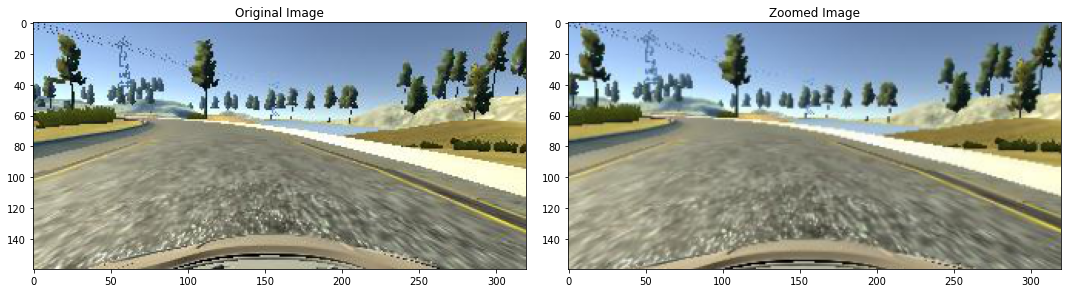

In [70]:
# zoom the image
def zoom(image):
  """
  Affine() :
   - draw a line
   -  1 : one image
   -  1.3 : 30% of the image
  """ 
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')



Text(0.5, 1.0, 'Panned Image')

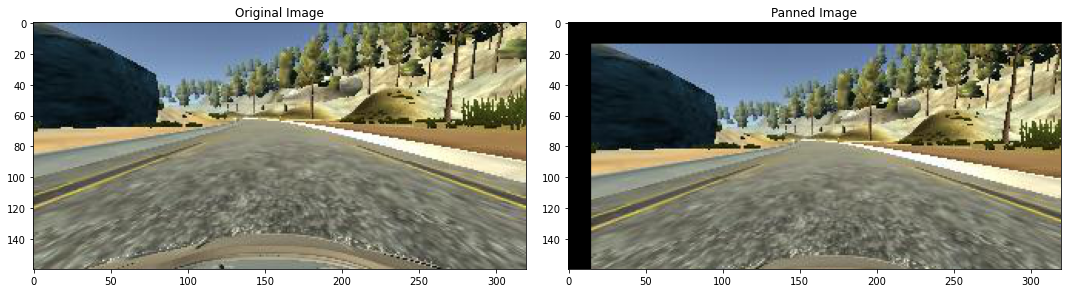

In [71]:
"""
Move the zoom image horizontally and vertically
x : 10% on left
y : 10% down
"""
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
  
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

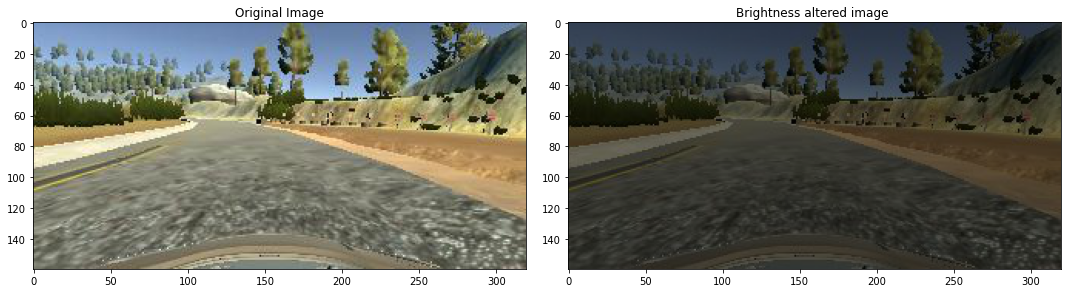

In [72]:
# change the brightness of the image randomly
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.007924363')

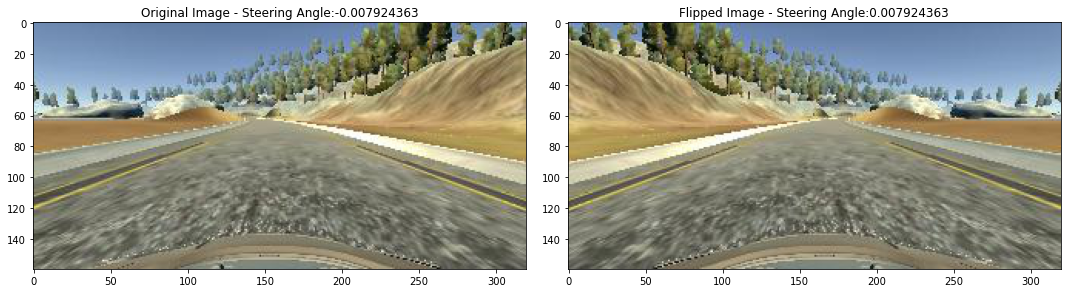

In [73]:
# flip the image in the other direction 
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

# get image from the dataset randomly  
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [74]:
# center the random image and flip
# allow to create more dataset the balance the image
# random augmentation every 50% of the time
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")    

Output hidden; open in https://colab.research.google.com to view.

**pre-processing**

In [75]:
# def gen (n):
#   i = 0
#   while i < n:
#     yield i
#     i = i + 1
    
# gen = gen(5)
# for i in gen:
#   print(i)

In [76]:
# Input data (Image) pre-processing
"""
- desc  : preprocess the input img
- details : the main idea is to format image, just like we were changing up the cameras position of the car
            by focusing on the important information overs noises or unsignificants information
input : input img
output : preprocessed img
"""
def img_preprocess(img):
    # img = mpimg.imread(img)
    # the image is 3D array (height, weight, channel nb)
    # reduce the height size to delete unneccessary top view for the car
    img = img[60:135,:,:]
    # convert RGB img to YUV for NVIDIA model (mandatory option from the NVIDIA spec)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # apply Gaussian Blur filter to reduce noise in the image
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    # resize the img based on NVIDIA input model
    img = cv2.resize(img, (200, 66))
    # normalization to 1 byte format
    img = img/255
    return img


In [77]:
# Test : load a specific img
# image = image_paths[100]
# # original img
# original_image = mpimg.imread(image)
# # preprocess img
# preprocessed_image = img_preprocess(original_image)
 
# fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')
# axs[1].imshow(preprocessed_image)
# axs[1].set_title('Preprocessed Image')

**Fit Generator**

Text(0.5, 1.0, 'Validation Image')

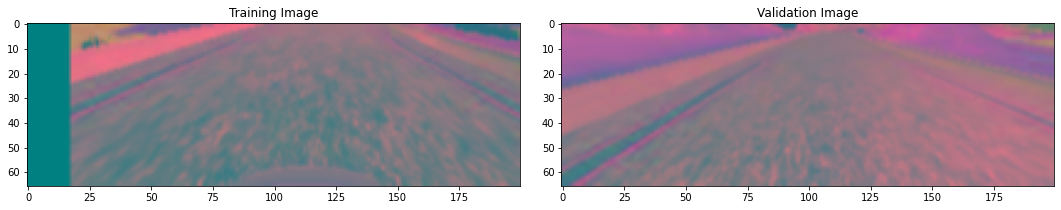

In [78]:
"""
Allows to generate new image based on input images

#### basic structure of a generator in python ####
def generator_name(params1, params2 ...):
  # statements
  yield(output1, output2 ...) 
"""
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  # infinite loop for the generator
  while True:
    # new images
    batch_img = []
    # new steering values
    batch_steering = []
    
    for i in range(batch_size):
      # take randomsly a new image
      random_index = random.randint(0, len(image_paths) - 1)
      # flag for training datas
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     # flag for validation datas
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      # preprocessing 
      im = img_preprocess(im)
      # append to batch list image
      batch_img.append(im)
      # append to batch steering
      batch_steering.append(steering)
    # return generated images and streering wheel values
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 
    
# get training data one by one
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
# get training data one by one
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [79]:
# print(X_train)
# X_train= np.array(list(map(img_preprocess, X_train)))
# X_valid= np.array(list(map(img_preprocess, X_valid)))

**Definig NVIDIA model**

In [88]:
"""
desc : intented for self-driving cloning because of the amount of complexity datasets
- remove dropout nodes because of generated data solve overfitting

src : https://arxiv.org/pdf/1604.07316.pdf
"""
def nvidia_model():
  # linear model type
  model = Sequential()
  # adding convolution NN layers
  # 1 layers
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  # 2 layers
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  # 3 layers
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  # /!\ remove sub sampling (2, 2) no longer necessary
  # 4 layers
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # 5 layers
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))

  # flattening image to a single one
  # 1 x 18 x 64 = 1152 
  model.add(Flatten())
  # 100 hidden nodes
  model.add(Dense(100, activation = 'elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))
  # opmitizer gradient descent 
  optimizer = Adam(lr=0.0004)
  # model compilation
  # cost function : mine square error
  model.compile(loss='mse', optimizer=optimizer)
  return model



In [89]:
# show model summary
model = nvidia_model()
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [90]:
"""
RELU => ELU for negative gradient which reduce the loss much quicker

"""
# Training
# history = model.fit(X_train, y_train,epochs=30, validation_data=(X_valid, y_valid),  batch_size=100, verbose=1, shuffle=1)
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 177s 591ms/step - loss: 0.1239 - val_loss: 0.0519
Epoch 2/10
300/300 [==============================] - 175s 586ms/step - loss: 0.0642 - val_loss: 0.0486
Epoch 3/10
300/300 [==============================] - 178s 596ms/step - loss: 0.0523 - val_loss: 0.0360
Epoch 4/10
300/300 [==============================] - 174s 581ms/step - loss: 0.0456 - val_loss: 0.0321
Epoch 5/10
300/300 [==============================] - 176s 588ms/step - loss: 0.0400 - val_loss: 0.0288
Epoch 6/10
300/300 [==============================] - 174s 581ms/step - loss: 0.0369 - val_loss: 0.0285
Epoch 7/10
300/300 [==============================] - 172s 576ms/step - loss: 0.0349 - val_loss: 0.0295
Epoch 8/10
300/300 [==============================] - 171s 571ms/step - loss: 0.0328 - val_loss: 0.0284
Epoch 9/10
300/300 [==============================] - 172s 576ms/step - loss: 0.0311 - val_loss: 0.0275
Epoch 10/10
300/300 [==============================] - 173s 578m

Text(0.5, 0, 'Epoch')

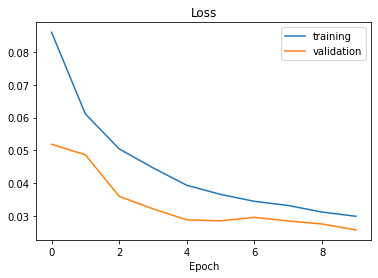

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [92]:
# Saving the trained model
model.save('model_gen.h5')
# download model
from google.colab import files
files.download('model_gen.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>